In [1]:
from sklearn.decomposition import KernelPCA
from sklearn.cross_validation import KFold
from sklearn import svm
import numpy as np
import random
import math
from sklearn.metrics import confusion_matrix as CM
from sklearn.ensemble import RandomForestClassifier as RFC

## Tuning rbf parameter

In [2]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits

In [3]:
def IndOfSortedFea(feaInfo):
    """return sorted index of a list"""
    sortInfo=sorted(feaInfo,reverse=True)
    ##for test
    ##print sortInfo
    return [feaInfo.index(i) for i in sortInfo]
#a=[3,4,6,2]
#print IndOfSortedFea(a)

In [4]:
def corDis(x,y):
    """
    calculate the correlation distance, given x and y calculate how similar the x and y is.
    return a value, 0 means x and y are independent, higher mean x are determinstic of y.
    """
    assert len(x)==len(y)
    n=len(x)
    a=np.zeros((n,n))
    b=np.zeros((n,n))
    ##calculate pair wise distance
    for i in xrange(n):
        for j in xrange(n):
            a[i,j]=np.linalg.norm(x[i]-x[j])
            b[i,j]=np.linalg.norm(y[i]-y[j])
    aRowMean=np.mean(a,axis=1)
    aColMean=np.mean(a,axis=0)
    bRowMean=np.mean(b,axis=1)
    bColMean=np.mean(b,axis=0)
    aMean=np.mean(a)
    bMean=np.mean(b)
    A=np.zeros((n,n))
    B=np.zeros((n,n))
    ##normalization
    for i in xrange(n):
        for j in xrange(n):
            A[i,j]=a[i,j]-aRowMean[i]-aColMean[j]+aMean
            B[i,j]=b[i,j]-bRowMean[i]-bColMean[j]+bMean
    cordis=0.
    for i in xrange(n):
        for j in xrange(n):
            cordis += A[i,j]*B[i,j]
    return cordis*(1./n**2)

In [5]:
#%matplotlib inline
from matplotlib import pyplot as plt
def plotFunction(x,y,text):
    n=x.shape[1]
    cols=2
    rows=int(math.ceil(n/2.))
    fig,ax=plt.subplots(ncols=cols,nrows=rows)
    if rows==1:
        for j in range(cols):
            if j<n:
                ax[j].scatter(x[:,j],y,c='b')
    else:
        for i in range(rows):
            for j in range(cols):
                if i*cols+j<n:
                    ax[i,j].scatter(x[:,i*cols+j],y,c='b')
                    #ax[i].title('x%d'%i,fontsize='small')
    plt.title(text)
    plt.show()


In [6]:
def crossValidation(x,y):
    """
    version 2
    according to the true y, predict
    greedy algorithm: first using index
    return
    """
    crossErrors=[]
    confusion_matrix=[]
    #svc=svm.LinearSVC()
    svc=svm.SVC(kernel='linear')
    kf = KFold(x.shape[0], n_folds=5,shuffle=True)
    for train,test in kf:
        svc.fit(x[train],y[train])
        prediction=svc.predict(x[test])
        crossErrors.append(((prediction!=y[test]).sum())/float(len(y[test])))
        confusion_matrix.append(CM(y[test],prediction))
    return np.mean(crossErrors),confusion_matrix

In [7]:
def crossValidation_forest(x,y):
    """
    version 3
    
    """
    crossErrors=[]
    confusion_matrix=[]
    #svc=svm.LinearSVC()
    rf=RFC(n_estimators=100,max_features=None)
    kf = KFold(x.shape[0], n_folds=5,shuffle=True)
    for train,test in kf:
        rf.fit(x[train],y[train])
        prediction=rf.predict(x[test])
        crossErrors.append(((prediction!=y[test]).sum())/float(len(y[test])))
        confusion_matrix.append(CM(y[test],prediction))
    return np.mean(crossErrors),confusion_matrix

In [50]:
def layer_rbf(x,y):
    """version 2"""
    kpca=KernelPCA(kernel='rbf',gamma=10.
                   ,n_components=x.shape[1])
    xT=kpca.fit_transform(x)
    rank=[]
    numOfFeatures=xT.shape[1]
    for i in xrange(numOfFeatures):
        rank.append(corDis(xT[:,i],y))
    feaSelected=IndOfSortedFea(rank)
    
    featureSelectedErrors=[]
    for i in xrange(numOfFeatures):
        crossErrors,cms=crossValidation_forest(xT[:,feaSelected[:i+1]],y)
        featureSelectedErrors.append(crossErrors)
    choice=featureSelectedErrors.index(min(featureSelectedErrors))
    return xT[:,feaSelected[:choice+1]],featureSelectedErrors,cms

In [9]:
def pretrain(x,y):
    rank=[]
    numOfFeatures=x.shape[1]
    for i in xrange(numOfFeatures):
        rank.append(corDis(x[:,i],y))
    feaSelected=IndOfSortedFea(rank)
    
    featureSelectedErrors=[]
    for i in xrange(numOfFeatures):
        crossErrors,cms=crossValidation_forest(x[:,feaSelected[:i+1]],y)
        featureSelectedErrors.append(crossErrors)
    choice=featureSelectedErrors.index(min(featureSelectedErrors))
    return x[:,feaSelected[:choice+1]],featureSelectedErrors,cms  

In [10]:
from matplotlib import pyplot as plt
def plotdata(x,y):
    n=x.shape[1]
    fig,ax=plt.subplots(ncols=n,nrows=n)
    fig.set_size_inches(10,7)
    for i in xrange(n):
        for j in xrange(i+1):
            for t,color in zip(xrange(3),'rgb'):
                ax[i][j].scatter(x[y == t,i],x[y == t,j],c=color)
    plt.show()
#plotdata(x,y)

In [11]:
def plotErr(err):
    x=range(len(err))
    #y=[e/min(err) for e in err]
    plt.bar(x,err)
    plt.title('Error Bar_Chart')
    plt.show()

In [12]:
def printCM(cm):
    """
    print cm in a nice way
    """
    for i in cm:
        print i
        print

In [51]:
iris=load_iris()
x=iris.data
y=iris.target

In [61]:
result,error,cm=pretrain(x,y)

In [62]:
plotdata(result,y)

In [29]:
printCM(cm)

[[11  0  0]
 [ 0 10  1]
 [ 0  0  8]]

[[ 8  0  0]
 [ 0 12  1]
 [ 0  0  9]]

[[13  0  0]
 [ 0  5  0]
 [ 0  2 10]]

[[11  0  0]
 [ 0  9  0]
 [ 0  0 10]]

[[ 7  0  0]
 [ 0 11  1]
 [ 0  1 10]]



In [63]:
plotErr(error)

In [64]:
result1,e1,cm1=layer_rbf(result,y)
printCM(cm1)

[[11  0  0]
 [ 0 10  0]
 [ 0  0  9]]

[[ 5  0  0]
 [ 0  9  1]
 [ 0  4 11]]

[[10  0  0]
 [ 0 12  0]
 [ 0  0  8]]

[[12  0  0]
 [ 0  7  2]
 [ 0  0  9]]

[[10  0  2]
 [ 0  8  1]
 [ 0  4  5]]



In [65]:
plotdata(result1,y)

In [66]:
plotErr(e1)

In [67]:
print result1.shape

(150L, 4L)


In [68]:
result2,e2,cm2=layer_rbf(result1,y)
printCM(cm2)

[[ 9  0  2]
 [ 0  7  0]
 [ 0  2 10]]

[[ 7  0  0]
 [ 0 11  2]
 [ 0  0 10]]

[[12  0  1]
 [ 0  6  0]
 [ 0  2  9]]

[[9 0 1]
 [0 9 1]
 [0 2 8]]

[[ 9  0  0]
 [ 0 10  4]
 [ 0  0  7]]



In [90]:
plotdata(result2,y)

In [70]:
plotErr(e2)

In [71]:
print result2.shape

(150L, 4L)


In [72]:
result3,e3,cm3=layer_rbf(result2,y)
printCM(cm3)

[[7 3 0]
 [0 6 2]
 [0 5 7]]

[[10  0  1]
 [ 1  4  4]
 [ 1  2  7]]

[[7 0 2]
 [2 5 7]
 [1 1 5]]

[[9 0 2]
 [0 8 0]
 [3 1 7]]

[[9 0 0]
 [1 8 2]
 [0 3 7]]



In [73]:
plotdata(result3,y)

In [76]:
plotErr(e3)

In [77]:
print result3.shape

(150L, 3L)


In [78]:
result4,e4,cm4=layer_rbf(result3,y)
printCM(cm4)

[[8 0 1]
 [1 8 1]
 [0 3 8]]

[[7 0 0]
 [1 8 3]
 [0 4 7]]

[[8 1 3]
 [0 9 3]
 [0 1 5]]

[[11  0  1]
 [ 2  3  2]
 [ 2  1  8]]

[[8 2 0]
 [0 6 3]
 [2 0 9]]



In [79]:
plotdata(result4,y)

In [80]:
plotErr(e4)

In [81]:
print result4.shape

(150L, 3L)


In [82]:
result5,e5,cm5=layer_rbf(result4,y)
printCM(cm5)

[[12  1  1]
 [ 1  6  1]
 [ 3  3  2]]

[[6 1 2]
 [2 4 5]
 [1 4 5]]

[[3 2 3]
 [1 7 2]
 [0 3 9]]

[[4 1 0]
 [1 9 1]
 [2 3 9]]

[[13  1  0]
 [ 1  6  3]
 [ 0  1  5]]



In [83]:
plotdata(result4,y)

In [84]:
plotErr(e5)

In [85]:
print result5.shape

(150L, 3L)


In [86]:
result6,e6,cm6=layer_rbf(result5,y)
printCM(cm6)

[[6 2 0]
 [2 3 4]
 [3 2 8]]

[[7 1 2]
 [2 9 4]
 [0 3 2]]

[[8 1 1]
 [2 7 2]
 [0 3 6]]

[[9 0 2]
 [2 2 4]
 [0 5 6]]

[[ 9  0  2]
 [ 0  4  3]
 [ 1  1 10]]



In [87]:
print result6.shape

(150L, 3L)


In [91]:
plotdata(result6,y)

In [89]:
plotErr(e6)

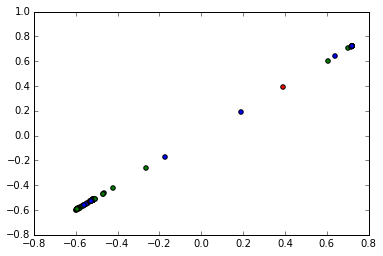

In [64]:
for t,color in zip(xrange(3),'rgb'):
    plt.scatter(result6[y == t],result6[y == t],c=color)
plt.show()

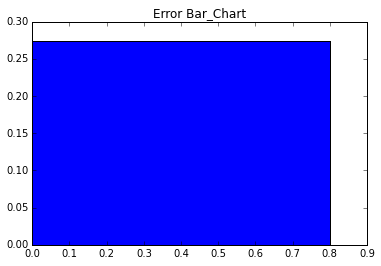

In [63]:
plotErr(e6)